In [176]:
from matplotlib import pyplot as plt
import pandas as pd
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from sklearn.metrics import accuracy_score
import numpy as np

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/new_incidents.csv')

# Data Cleaning

The names of the counties are not consistent, so we need to unify them. We will use fuzzywuzzy's matching to find similar names and try to preprocess the strings to minimize the number of typos and abbreviations. We will also remove punctuation characters and extra spaces, and transform the names to title case. For a few cases where the names are very different, we will use a mapping dictionary to unify the ones we noticed.

In [177]:
# filter the incidents where year is between 2014 and 2017 and create the is_killed label
df = df[(df['year'] >= 2014) & (df['year'] <= 2017)]
df["is_killed"] = df["n_killed"] > 0

In [178]:
from fuzzywuzzy import fuzz

# Group counties by state
grouped_by_state = df.groupby('state')['city_or_county'].unique()

# Iterate through each state to find similar county names
for state, counties_in_state in grouped_by_state.items():
    # Iterate through each pair of counties within the state
    for i in range(len(counties_in_state)):
        for j in range(i + 1, len(counties_in_state)):
            similarity_ratio = fuzz.ratio(counties_in_state[i], counties_in_state[j])
            if similarity_ratio > 90:  # Adjust the threshold as needed
                print(
                    f"Similarity between '{counties_in_state[i]}' and '{counties_in_state[j]}' in {state} - Ratio: {similarity_ratio}")

Similarity between 'Mobile' and 'Mobile ' in Alabama - Ratio: 92
Similarity between 'Bessemer' and 'Bessemer ' in Alabama - Ratio: 94
Similarity between 'Florence' and 'Florence ' in Alabama - Ratio: 94
Similarity between 'Dekalb County' and 'DeKalb County' in Alabama - Ratio: 92
Similarity between 'Mc Calla (McCalla)' and 'Mc Calla (Mccalla)' in Alabama - Ratio: 94
Similarity between 'Mojave (county)' and 'Mohave (county)' in Arizona - Ratio: 93
Similarity between 'Little Rock' and 'Little Rock ' in Arkansas - Ratio: 96
Similarity between 'Fort Smith' and 'Fort Smith ' in Arkansas - Ratio: 95
Similarity between 'Pine Bluff' and 'Pine Bluff ' in Arkansas - Ratio: 95
Similarity between 'Helena-west Helena' and 'Helena-West Helena' in Arkansas - Ratio: 94
Similarity between 'Mc Farland' and 'McFarland' in California - Ratio: 95
Similarity between 'Santa Clarita' and 'Santa Clara' in California - Ratio: 92
Similarity between 'Hollywood' and 'Hollywood ' in California - Ratio: 95
Similarit

In [179]:
# preprocess county names to unify typos and different abbreviations
counties = df['city_or_county'].unique()
# Apply a regex-based replacement to unify the "county" suffix
df['city_or_county'] = df['city_or_county'].str.replace(r'\s+\(county\)$', ' County', regex=True)
# Replace punctuation characters with spaces
df['city_or_county'] = df['city_or_county'].str.replace(r'[^\w\s]|(?<=\w)-(?=\w)', ' ', regex=True)
# Replace 'St ' with 'Saint'
df['city_or_county'] = df['city_or_county'].str.replace(r'\bSt\b', 'Saint', regex=True)
# Replace "Pk" with "Park"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bPk\b', 'Park', regex=True)
# Replace "Mt" with "Mount"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bMt\b', 'Mount', regex=True)
# Replace "Twp" with "Township"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bTwp\b', 'Township', regex=True)
# Replace "Washingtn" with "Washington"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bWashingtn\b', 'Washington', regex=True)

# Remove extra spaces
df['city_or_county'] = df['city_or_county'].str.replace(r'\s+', ' ', regex=True)
# Transform to title case and strip leading and trailing spaces
df['city_or_county'] = df['city_or_county'].str.strip().str.title()

# Mapping dictionary for unifying similar names, found with fuzzy matching
unify_dict = {
    'Denver Northglenn': 'Denver North Glenn',
    'Baton Rogue': 'Baton Rouge',
    'Marrrero': 'Marrero',
    'Prince George S County': 'Prince Georges County',
    'Genessee County': 'Genesee County',
    'O Fallon Ofallon': 'O Fallon O Fallon',
    'Doña Ana County': 'Dona Ana County',
    'Ullster County': 'Ulster County',
    'Nelsonvlle': 'Nelsonville',
    'Wolf Creek Sunnyvalley': 'Wolf Creek Sunny Valley',
    'Pittsburgh Bellvue': 'Pittsburgh Bellevue',
    'Mojave County': 'Mohave County',
    'New York Manhattan': 'Manhattan'
}

df['city_or_county'] = df['city_or_county'].replace(unify_dict)

# Score Calculation
We will calculate a score for each incident, based on the number of participants and how serious it was. We will assign heavier weights to incidents with more victims, and we will also consider the number of unharmed participants as negative weight. Then, we will group the incidents by year and week, to calculate the sum of the scores for each week later.

In [180]:
# Extract a time series for each city, computing for each week of the 4 years a score
df['date'] = pd.to_datetime(df['date'])
df['score'] = df.n_participants + df.n_killed * (
        2 + df.n_killed / df.n_participants) + df.n_injured - 0.25 * df.n_unharmed


# Define a function to calculate the unique week index considering leap years
def calculate_unique_week(date):
    if date.year == 2016:  # account for the leap year
        return date.isocalendar().week + (date.year - 2014) * 53
    else:
        return date.isocalendar().week + (date.year - 2014) * 52


# Apply the function to create the unique week index column
df['week'] = df['date'].apply(calculate_unique_week)

# Filter Cities
We will filter the cities to keep only the ones with a significant number of incidents. We will calculate the percentage of weeks with incidents for each city, and we will keep only the ones with more than 25% weeks with incidents. This will help to avoid having too many time series with a lot of missing values.

In [181]:
# Group by city and week, count incidents, and calculate score
grouped = df.groupby([df['city_or_county'],
                      df['week']]).size().reset_index(name='incident_count')
# Count total weeks for each city
city_week_counts = grouped['city_or_county'].value_counts()

# Calculate the total number of weeks from 2014 to 2017
total_weeks = len(grouped['week'].unique())

# Calculate percentage of weeks with incidents for each city
city_week_percentage = city_week_counts / total_weeks

# Filter cities with more than 25% weeks with incidents
selected_cities = city_week_percentage[city_week_percentage > 0.25].index
filtered = df[df['city_or_county'].isin(selected_cities)]
# Filter the grouped DataFrame for selected cities
filtered_grouped = filtered.groupby([df['city_or_county'],
                                     df['week']])['score'].sum().reset_index()

In [182]:
filtered_grouped

city_or_county  week     score
0            Abilene     4  2.750000
1            Abilene    22  3.000000
2            Abilene    23  7.333333
3            Abilene    24  4.500000
4            Abilene    27  2.750000
...              ...   ...       ...
41160      Ypsilanti   192  2.750000
41161      Ypsilanti   194  2.000000
41162      Ypsilanti   195  2.000000
41163      Ypsilanti   203  4.750000
41164      Ypsilanti   208  4.500000

[41165 rows x 3 columns]

# Time Series 

In [183]:
# Pivot the DataFrame to create the time series
time_series = filtered_grouped.pivot(index='city_or_county', columns='week', values='score')

# Optionally, fill missing values with 0 if a city has no incidents in a certain week
time_series.fillna(0, inplace=True)

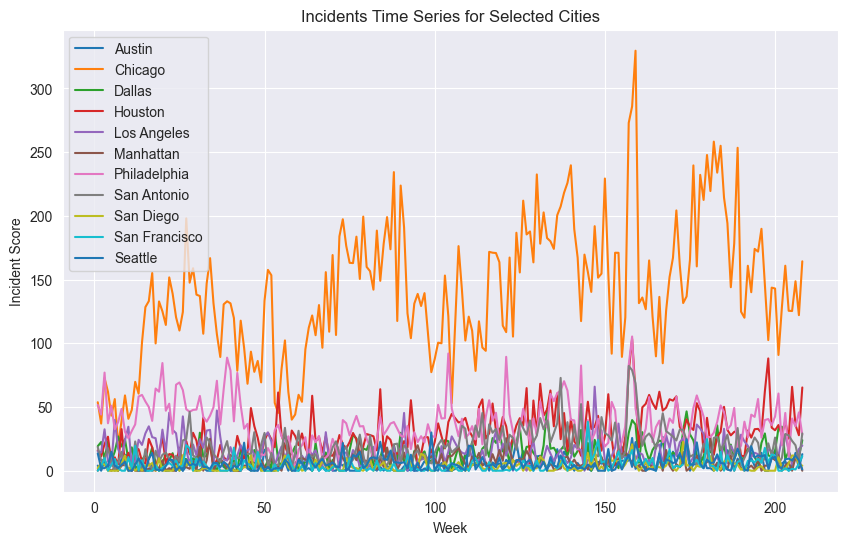

In [184]:
cities_to_plot = ['Austin', 'Chicago', 'Dallas', 'Houston', 'Los Angeles', 'Manhattan', 'Philadelphia', 'San Antonio',
                  'San Diego', 'San Francisco', 'Seattle']
plt.figure(figsize=(10, 6))  # Set the figure size

for city in cities_to_plot:
    plt.plot(time_series.columns, time_series.loc[city], label=city)  # Plot each city's time series

plt.title('Incidents Time Series for Selected Cities')
plt.xlabel('Week')
plt.ylabel('Incident Score')
plt.legend()
plt.grid(True)
plt.show()

# Detrending

Check for stationarity using the Augmented Dickey-Fuller test

In [185]:
from statsmodels.tsa.stattools import adfuller

non_stationary_cities = []

for city in time_series.columns:
    adf = adfuller(time_series[city])
    pvalue = adf[1]
    if pvalue > 0.05:
        non_stationary_cities.append(city)

print(len(non_stationary_cities))

0


In [186]:
time_series_detrend = time_series.copy()
for col in non_stationary_cities:
    time_series_detrend[col] = time_series[col] - time_series[col].rolling(window=12, min_periods=1).mean()

## Denoising

In [187]:
import numpy as np

noise_windows = np.array(range(1, 15))

# Dictionary to store mean SAD scores for each window size
mean_sad_dict = {}

for window_size in noise_windows:
    sum_abs_diff_weeks = []

    for week in time_series_detrend.index:
        smoothed_series = time_series_detrend.loc[week].rolling(window=window_size, center=True, min_periods=1).mean()
        sum_abs_diff_single_per_week = np.sum(np.abs(smoothed_series - time_series_detrend.loc[week]))
        sum_abs_diff_weeks.append(sum_abs_diff_single_per_week)

    mean_sad_dict[window_size] = np.average(sum_abs_diff_weeks)

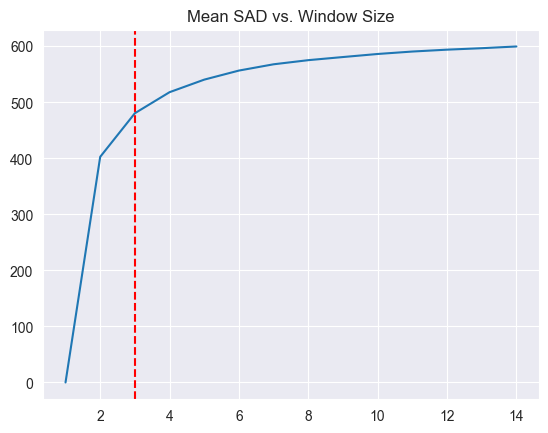

In [188]:
plt.plot(mean_sad_dict.keys(), mean_sad_dict.values())
plt.axvline(3, color='red', linestyle='--')
plt.title('Mean SAD vs. Window Size')
plt.show()

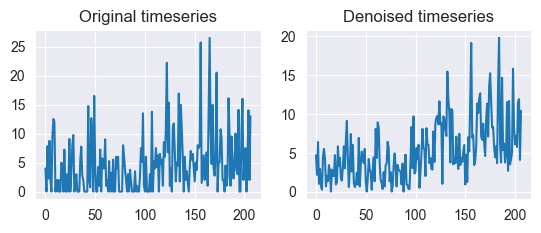

In [189]:
# Denoise the time series with found window size
time_series_denoised = time_series_detrend.rolling(window=3, center=True, min_periods=1).mean()

ts_example = time_series.loc['Austin']
ts_example_denoised = time_series_denoised.loc['Austin']

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(ts_example.to_numpy())
ax1.set_title('Original timeseries')
ax1.set_box_aspect(3 / 4)

ax2.plot(ts_example_denoised.to_numpy())
ax2.set_title('Denoised timeseries')
ax2.set_box_aspect(3 / 4)

plt.show()

## Scaling

In [190]:
# Normalize the time series with scaler mean variance
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

scaler = TimeSeriesScalerMeanVariance(0, .1)
time_series_normalized = scaler.fit_transform(time_series_denoised)

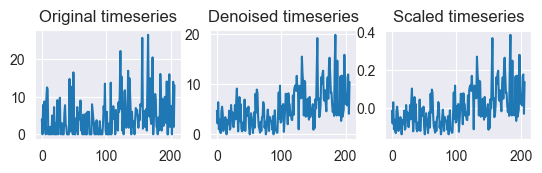

In [191]:
time_series = pd.DataFrame(time_series_normalized.squeeze(axis=-1), columns=time_series_denoised.columns,
                           index=time_series_denoised.index)
ts_example_scaled = time_series.loc['Austin']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(ts_example.to_numpy())
ax1.set_title('Original timeseries')
ax1.set_box_aspect(3 / 4)

ax2.plot(ts_example_denoised.to_numpy())
ax2.set_title('Denoised timeseries')
ax2.set_box_aspect(3 / 4)

ax3.plot(ts_example_scaled.to_numpy())
ax3.set_title('Scaled timeseries')
ax3.set_box_aspect(3 / 4)
plt.show()

In [192]:
cities_to_plot = ['Austin', 'Chicago', 'Dallas', 'Houston', 'Los Angeles', 'Manhattan', 'Philadelphia', 'San Antonio',
                  'San Diego', 'San Francisco', 'Seattle']

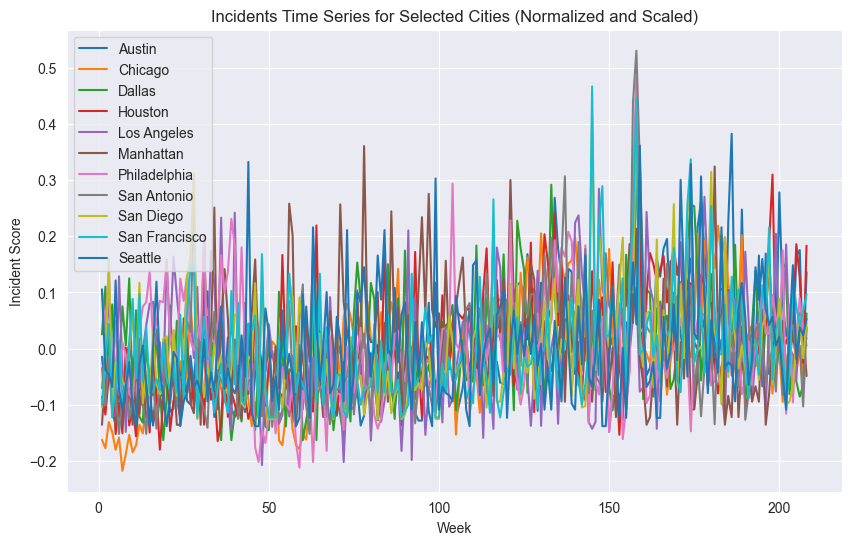

In [193]:
plt.figure(figsize=(10, 6))  # Set the figure size

for city in cities_to_plot:
    plt.plot(time_series.columns, time_series.loc[city], label=city)  # Plot each city's time series

plt.title('Incidents Time Series for Selected Cities (Normalized and Scaled)')
plt.xlabel('Week')
plt.ylabel('Incident Score')
plt.legend()
plt.grid(True)
plt.show()

## Clustering Utility Methods

In [194]:
# plots the time series for each cluster
def plot_clustered_time_series(time_series, cluster_labels, n_clusters, colors=['red', 'blue', 'green', 'orange']):
    fig, axs = plt.subplots(n_clusters, figsize=(10, 6), sharex=True)

    for cluster in range(n_clusters):
        cluster_indices = [idx for idx, label in enumerate(cluster_labels) if label == cluster]
        for idx in cluster_indices:
            axs[cluster].plot(time_series.columns, time_series.iloc[idx], color=colors[cluster])

        axs[cluster].set_title(f'Cluster {cluster + 1}')
        axs[cluster].grid(True)
        print(f'Cluster {cluster + 1} length: {len(cluster_indices)}')

    plt.xlabel('Weeks')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.show()

In [195]:
# plots the pie charts for each cluster, after merging the clusters with the original dataframe
# to show the number of participants, ratio of males, killed and minors for each cluster
def pie_plot(df_to_plot):
    # Create subplots with 2 rows and 2 columns
    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    
    # Plot for 'n_participants'
    df_to_plot.groupby('cluster_id')['n_participants'].mean().plot(kind='pie', autopct='%1.1f%%', ax=axs[0, 0])
    axs[0, 0].set_title('Mean Participants per Cluster')
    
    # Plot for 'n_killed'
    df_to_plot.groupby('cluster_id')['n_killed'].mean().plot(kind='pie', autopct='%1.1f%%', ax=axs[0, 1])
    axs[0, 1].set_title('Mean Killed per Cluster')
    
    # Plot for 'n_minors'
    df_to_plot.groupby('cluster_id')['n_minors'].mean().plot(kind='pie', autopct='%1.1f%%', ax=axs[1, 0])
    axs[1, 0].set_title('Mean Minors per Cluster')
    
    # Plot for 'man_to_p'
    df_to_plot.groupby('cluster_id')['man_to_p'].mean().plot(kind='pie', autopct='%1.1f%%', ax=axs[1, 1])
    axs[1, 1].set_title('Mean Male Ratio per Cluster')

    plt.tight_layout()
    plt.show()


In [196]:
import plotly.express as px

# plots the USA map with the cities colored by cluster, to show the geographic distribution
def plot_clustered_map(df_to_plot):
    # Group data by city_or_county and calculate mean latitude and longitude
    grouped_data = df_to_plot.groupby('city_or_county').agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()

    # Get the cluster_id for each city_or_county
    cluster_info = df_to_plot[['city_or_county', 'cluster_id']].drop_duplicates()

    # Merge cluster information with the grouped data
    grouped_data = pd.merge(grouped_data, cluster_info, on='city_or_county')

    # Create a scatter plot on the map using Plotly Express
    fig = px.scatter_mapbox(grouped_data, lat='latitude', lon='longitude', color='cluster_id',
                            color_continuous_scale='Viridis', zoom=3, height=500,
                            hover_name='city_or_county')

    # Update map layout and style
    fig.update_layout(mapbox_style='open-street-map')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

    # Show the map
    fig.show()

# Shape Based Clustering

## Euclidean KMeans

In [197]:
from tslearn.clustering import TimeSeriesKMeans

In [198]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

inertia = []
davies_list = []
sil_list = []

for k in range(2, 12):
    model = TimeSeriesKMeans(n_clusters=k, n_init=10)
    model.fit(time_series)
    inertia.append(model.inertia_)
    davies_list.append(davies_bouldin_score(time_series, model.labels_))
    sil_list.append(silhouette_score(time_series, model.labels_))

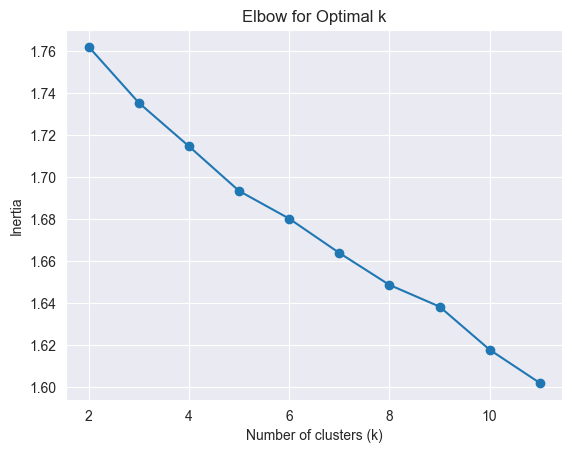

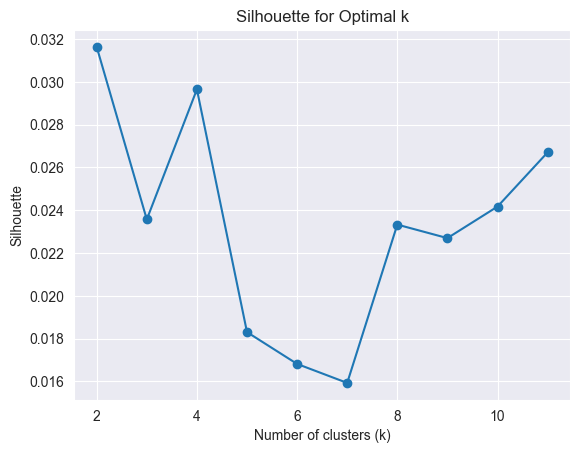

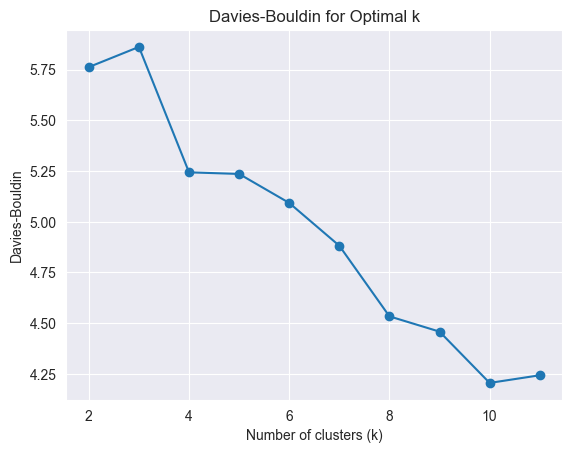

In [199]:
# Plot the inertia values against k
plt.plot(range(2, 12), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow for Optimal k')
plt.show()
# Plot the Silhouette values against k
plt.plot(range(2, 12), sil_list, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette')
plt.title('Silhouette for Optimal k')
plt.show()
# Plot the Davies-Bouldin values against k
plt.plot(range(2, 12), davies_list, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin')
plt.title('Davies-Bouldin for Optimal k')
plt.show()

In [200]:
n_clusters = 7  # You can adjust the number of clusters as needed
kmeans = TimeSeriesKMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(time_series)

Cluster 1 length: 23
Cluster 2 length: 53
Cluster 3 length: 64
Cluster 4 length: 55
Cluster 5 length: 55
Cluster 6 length: 74
Cluster 7 length: 40


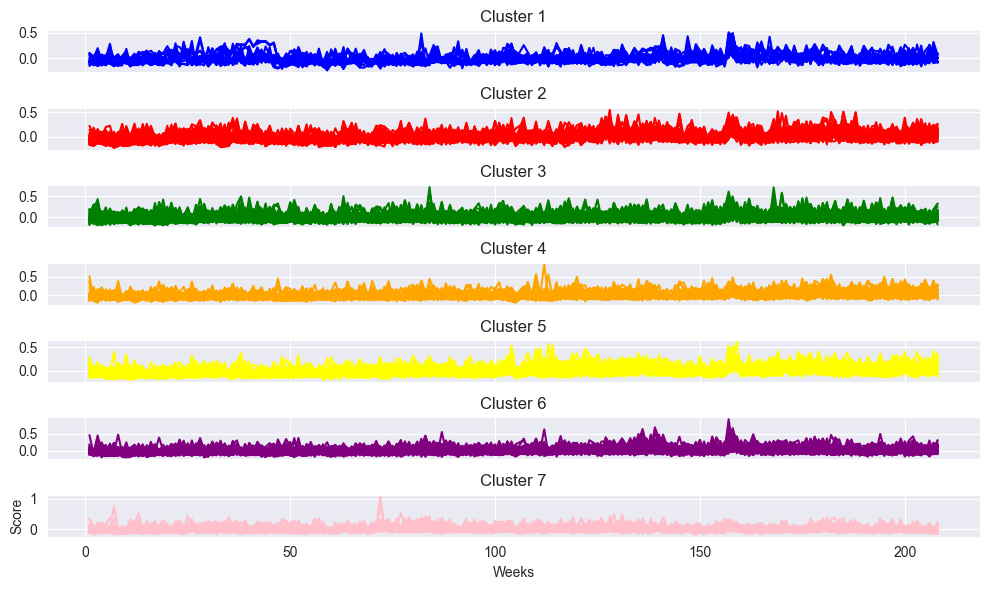

In [201]:
colors = ['blue', 'red', 'green', 'orange', 'yellow', 'purple', 'pink']  # Assign different colors for each cluster

plot_clustered_time_series(time_series, cluster_labels, n_clusters, colors)

In [202]:
# create a new dataframe with the cluster labels and the city names
clustered_cities = pd.DataFrame({'city_or_county': time_series.index, 'cluster_id': cluster_labels})
# merge the dataframe with cluster labels with the filtered dataframe
clustered_df = pd.merge(filtered, clustered_cities, on='city_or_county')

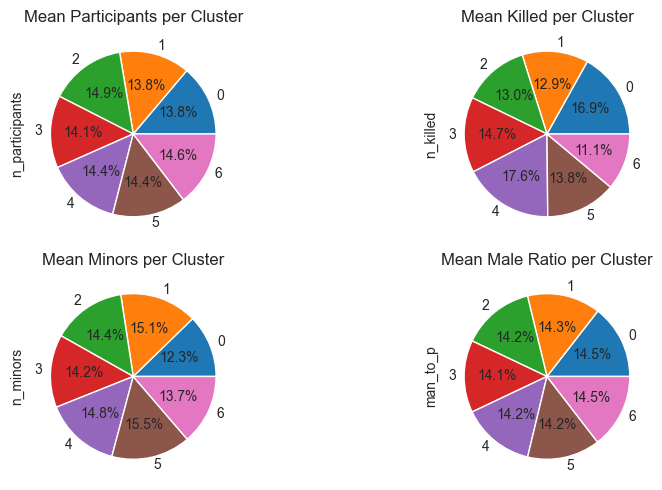

In [203]:
# pie plots of data in each cluster
pie_plot(clustered_df)

In [204]:
plot_clustered_map(clustered_df)

## Dimensional Time Warping

In [205]:
from tslearn.clustering import TimeSeriesKMeans

In [206]:
distortions = []
davies_list = []
sil_list = []

K = range(2, 12)  # Test k values
for k in K:
    km = TimeSeriesKMeans(n_clusters=k, metric="dtw", verbose=0, random_state=42, n_init=5)
    km.fit(time_series)
    distortions.append(km.inertia_)
    davies_list.append(davies_bouldin_score(time_series, km.labels_))
    sil_list.append(silhouette_score(time_series, km.labels_))

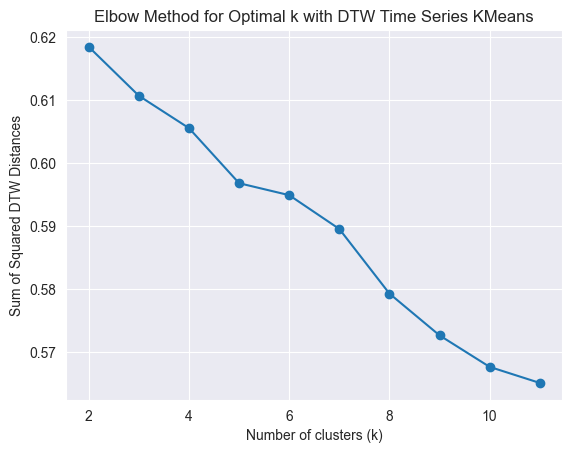

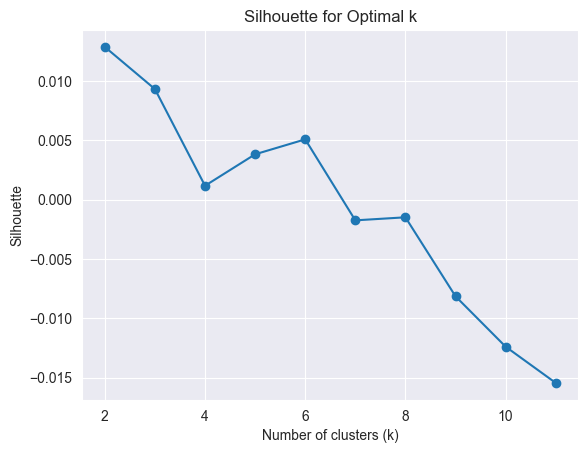

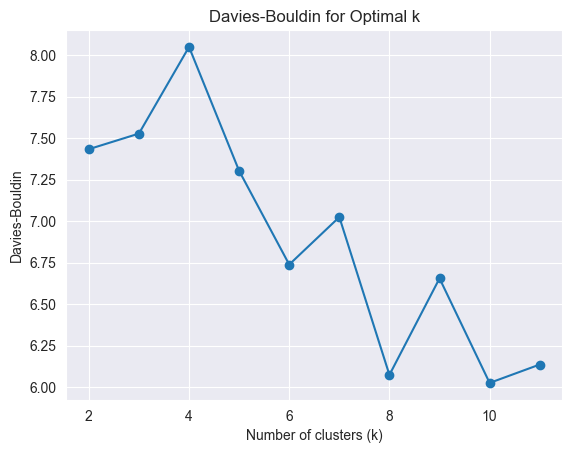

In [207]:
# Plotting the elbow method graph
plt.plot(K, distortions, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared DTW Distances')
plt.title('Elbow Method for Optimal k with DTW Time Series KMeans')
plt.show()
# Plot the Silhouette values
plt.plot(K, sil_list, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette')
plt.title('Silhouette for Optimal k')
plt.show()
# Plot the Davies-Bouldin values
plt.plot(K, davies_list, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin')
plt.title('Davies-Bouldin for Optimal k')
plt.show()

In [208]:
n_clusters = 6
kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_init=5, random_state=42)
cluster_labels = kmeans_dtw.fit_predict(time_series)

Cluster 1 length: 17
Cluster 2 length: 79
Cluster 3 length: 72
Cluster 4 length: 109
Cluster 5 length: 57
Cluster 6 length: 30


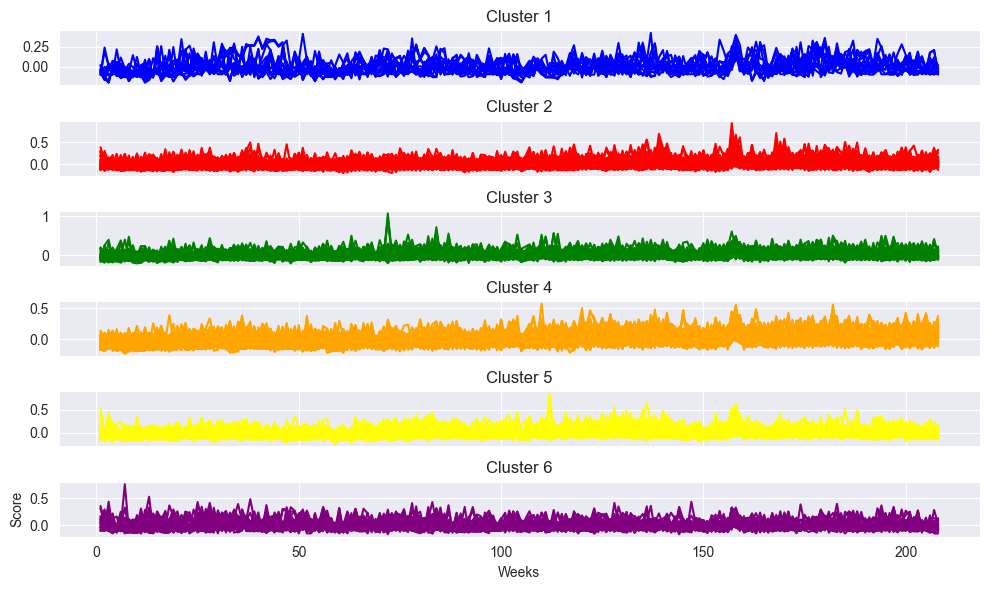

In [209]:
colors = ['blue', 'red', 'green', 'orange', 'yellow', 'purple']  # Assign different colors for each cluster

plot_clustered_time_series(time_series, kmeans_dtw.labels_, n_clusters, colors)

In [210]:
# create a new dataframe with the cluster labels and the city names
clustered_cities_dtw = pd.DataFrame({'city_or_county': time_series.index, 'cluster_id': cluster_labels})
# merge the dataframe with cluster labels with the filtered dataframe
clustered_df_dtw = pd.merge(filtered, clustered_cities_dtw, on='city_or_county')

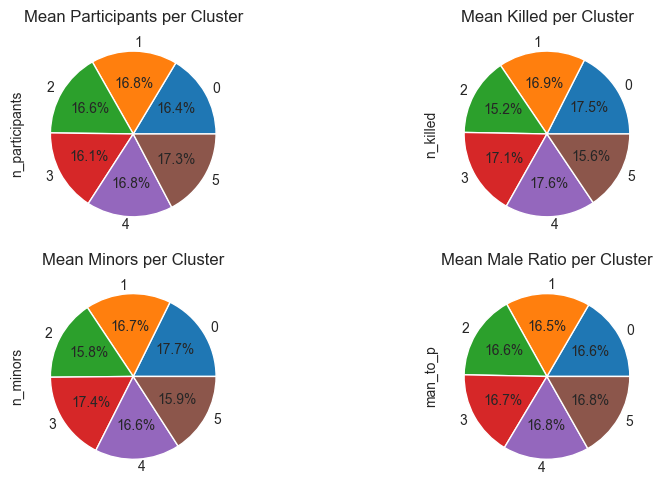

In [211]:
# pie plots of data in each cluster
pie_plot(clustered_df_dtw)

In [212]:
plot_clustered_map(clustered_df_dtw)

# Feature based clustering

As features, we will use the mean, standard deviation, variance, median, 10th, 25th, 50th, 75th and 90th percentiles, interquartile range, skewness and kurtosis of the time series.

In [213]:
import scipy.stats as stats

# calculate the features for each time series, to use them for clustering
def calculate_features(values):
    features = {
        'avg': np.mean(values, axis=0),
        'std': np.std(values, axis=0),
        'var': np.var(values, axis=0),
        'med': np.median(values, axis=0),
        '10p': np.percentile(values, 10, axis=0),
        '25p': np.percentile(values, 25, axis=0),
        '50p': np.percentile(values, 50, axis=0),
        '75p': np.percentile(values, 75, axis=0),
        '90p': np.percentile(values, 90, axis=0),
        'iqr': np.percentile(values, 75, axis=0) - np.percentile(values, 25, axis=0),
        'skw': stats.skew(values, axis=0),
        'kur': stats.kurtosis(values, axis=0)
    }

    return features


In [214]:
time_series_features = [list(calculate_features(ts.values).values()) for _, ts in time_series.iterrows()]

## KMeans

In [215]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans


def k_means_calculation(df):
    sse, davies, silhouette = [], [], []
    max_k = 15
    for k in range(2, max_k + 1):
        kmeans_pass = KMeans(n_clusters=k, n_init=10, max_iter=300)
        kmeans_pass.fit(df)
        sse_pass = kmeans_pass.inertia_
        sse.append(sse_pass)
        davies.append(davies_bouldin_score(df, kmeans_pass.labels_))
        silhouette.append(silhouette_score(df, kmeans_pass.labels_))
    plt.plot(range(2, len(sse) + 2), sse)
    plt.ylabel('SSE')
    plt.xlabel('K')
    plt.title('SSE')
    plt.show()
    plt.plot(range(2, len(davies) + 2), davies)
    plt.ylabel('DAVIES')
    plt.xlabel('K')
    plt.title('DAVIES')
    plt.show()
    plt.plot(range(2, len(silhouette) + 2), silhouette)
    plt.ylabel('SILHOUETTE')
    plt.xlabel('K')
    plt.title('SILHOUETTE')
    plt.show()



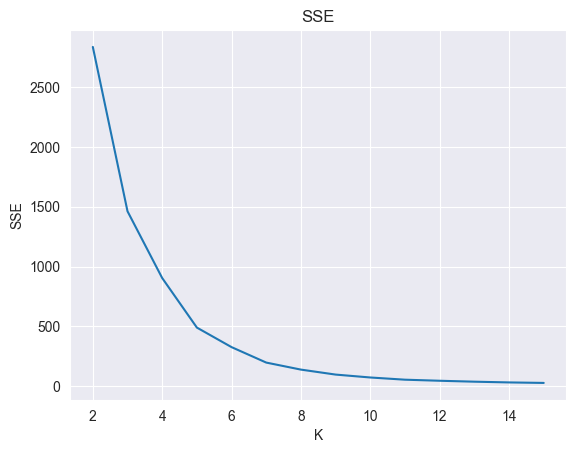

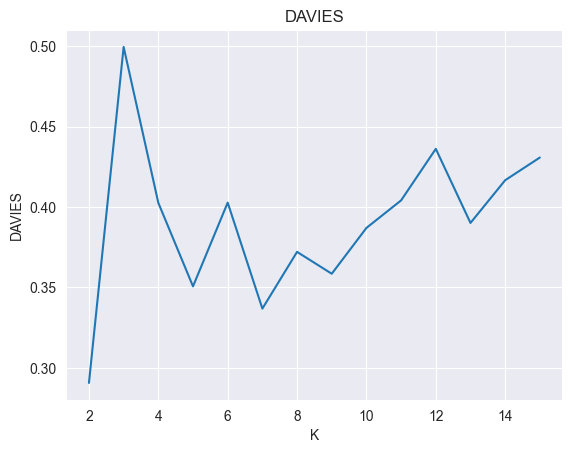

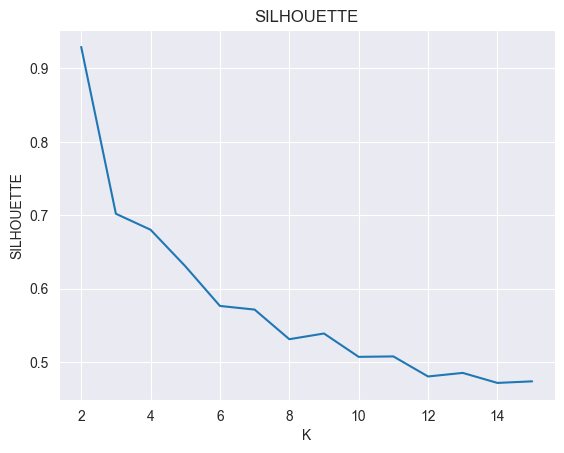

In [216]:
k_means_calculation(time_series_features)

In [217]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(time_series_features)

KMeans(n_clusters=5, n_init=10)

Cluster 1 length: 258
Cluster 2 length: 1
Cluster 3 length: 3
Cluster 4 length: 88
Cluster 5 length: 14


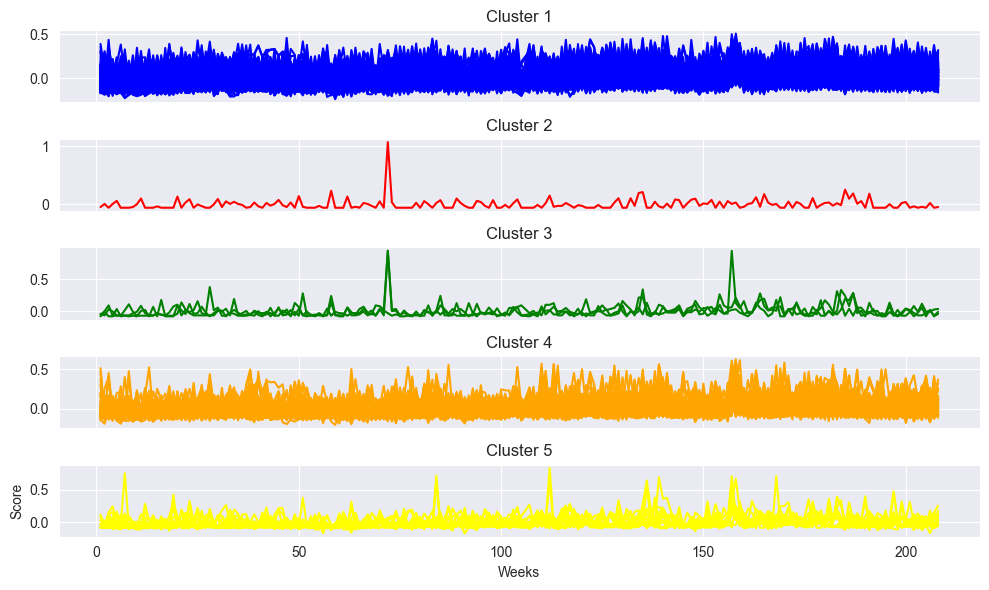

In [218]:
colors = ['blue', 'red', 'green', 'orange', 'yellow', 'purple']  # Assign different colors for each cluster
cluster_labels = kmeans.labels_
plot_clustered_time_series(time_series, cluster_labels, n_clusters, colors)

In [219]:
# create a new dataframe with the cluster labels and the city names
clustered_cities = pd.DataFrame({'city_or_county': time_series.index, 'cluster_id': cluster_labels})
# merge the dataframe with cluster labels with the filtered dataframe
clustered_df = pd.merge(filtered, clustered_cities, on='city_or_county')

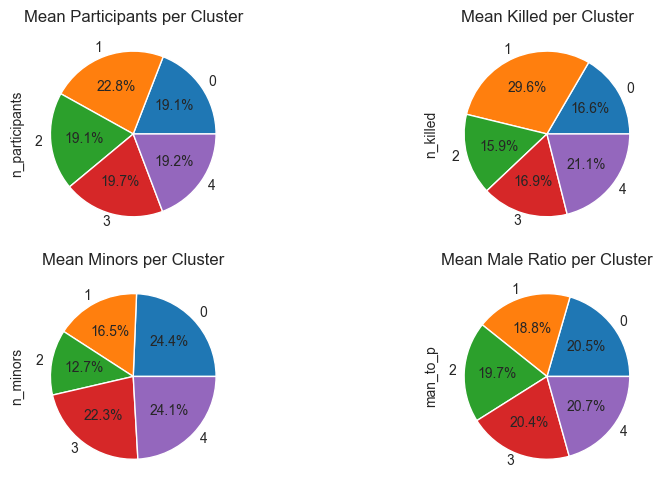

In [220]:
pie_plot(clustered_df)
plot_clustered_map(clustered_df)

## Hierarchical

In [221]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_std = StandardScaler().fit_transform(time_series_features)
X_minmax = MinMaxScaler().fit_transform(time_series_features)


Standard scaling


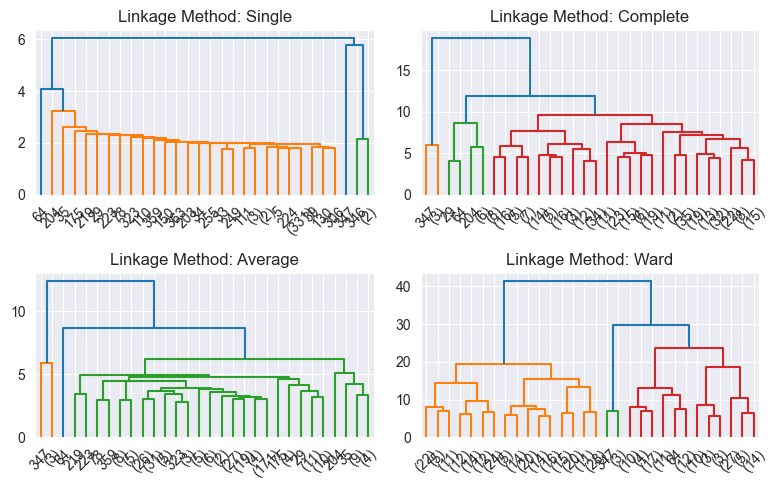

In [222]:
# List of linkage methods
linkage_methods = ['single', 'complete', 'average', 'ward']

print("Standard scaling")
# Calculating pairwise distances
data_dist = pdist(X_std, metric='euclidean')
color_tresholds = [4, 10, 7, 25]

# Creating subplots for each dendrogram
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

for i, method in enumerate(linkage_methods):
    # Calculate linkage for each method
    data_link = linkage(data_dist, method=method, metric='euclidean')

    # Determine subplot position
    row = i // 2
    col = i % 2

    # Plot dendrogram for each method
    dendrogram(data_link, ax=axs[row, col], color_threshold=color_tresholds[i], truncate_mode='lastp')
    axs[row, col].set_title(f"Linkage Method: {method.capitalize()}")

# Adjust layout and display
plt.tight_layout()
plt.show()

Minmax scaling


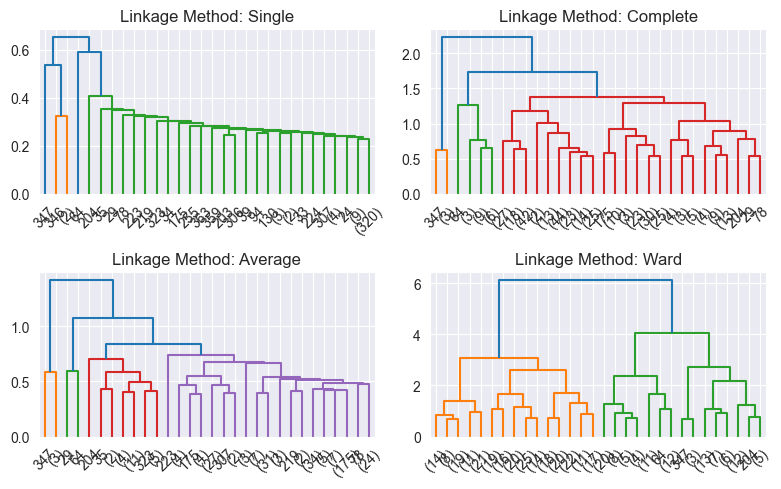

In [223]:
print("Minmax scaling")

# Calculating pairwise distances
data_dist = pdist(X_minmax, metric='euclidean')
color_tresholds = [0.5, 1.5, 0.8, 5]

# Creating subplots for each dendrogram
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

for i, method in enumerate(linkage_methods):
    # Calculate linkage for each method
    data_link = linkage(data_dist, method=method, metric='euclidean')

    # Determine subplot position
    row = i // 2
    col = i % 2

    # Plot dendrogram for each method
    dendrogram(data_link, ax=axs[row, col], color_threshold=color_tresholds[i], truncate_mode='lastp')
    axs[row, col].set_title(f"Linkage Method: {method.capitalize()}")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [224]:
from sklearn.cluster import AgglomerativeClustering

def hierarchical_clustering_test(X, n_clusters, linkage_method):
    hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage=linkage_method)
    cluster_labels = hierarchical_clustering.fit_predict(X)
    sil_score = silhouette_score(X, hierarchical_clustering.labels_)
    print(f"Silhouette Score (n_clusters={n_clusters}, linkage={linkage_method}): {sil_score}")
    unique_clusters, cluster_counts = np.unique(cluster_labels, return_counts=True)
    for cluster_id, count in zip(unique_clusters, cluster_counts):
        print(f"Cluster {cluster_id}: {count} points")


In [225]:
# Test the clustering with different configurations
hierarchical_clustering_test(X_std, n_clusters=2, linkage_method='ward')
hierarchical_clustering_test(X_minmax, n_clusters=2, linkage_method='ward')
hierarchical_clustering_test(X_minmax, n_clusters=3, linkage_method='ward')

Silhouette Score (n_clusters=2, linkage=ward): 0.27050979543038606
Cluster 0: 121 points
Cluster 1: 243 points
Silhouette Score (n_clusters=2, linkage=ward): 0.32717321871234556
Cluster 0: 109 points
Cluster 1: 255 points
Silhouette Score (n_clusters=3, linkage=ward): 0.29761437150056114
Cluster 0: 255 points
Cluster 1: 48 points
Cluster 2: 61 points


In [226]:
hierarchical_clustering = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage="ward")
cluster_labels = hierarchical_clustering.fit_predict(X_minmax)

In [227]:
# create a new dataframe with the cluster labels and the city names
clustered_cities = pd.DataFrame({'city_or_county': time_series.index, 'cluster_id': cluster_labels})
# merge the dataframe with cluster labels with the filtered dataframe
clustered_df = pd.merge(filtered, clustered_cities, on='city_or_county')

Cluster 1 length: 109
Cluster 2 length: 255


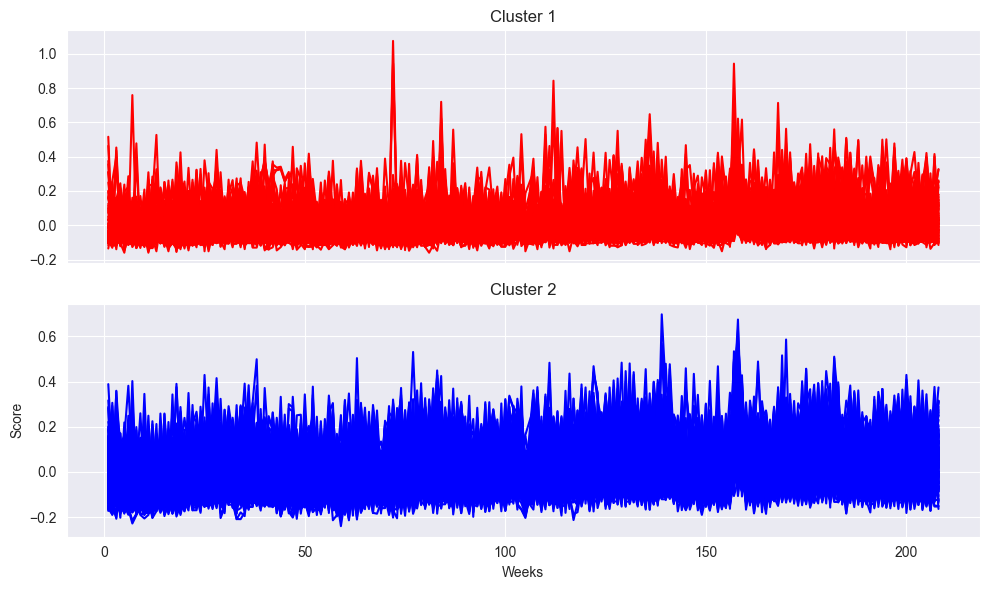

In [228]:
plot_clustered_time_series(time_series, cluster_labels, 2)

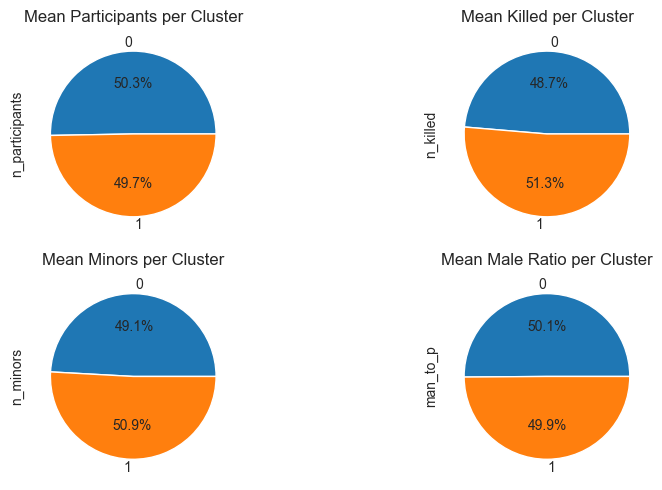

In [229]:
pie_plot(clustered_df)
plot_clustered_map(clustered_df)

# Motifs and Anomalies
We take the results from the DTW clustering and find the most similar time series to each cluster's centroid. We will use the DTW distance to find the most similar time series to each centroid, which will be used for motif discovery and anomaly detection.

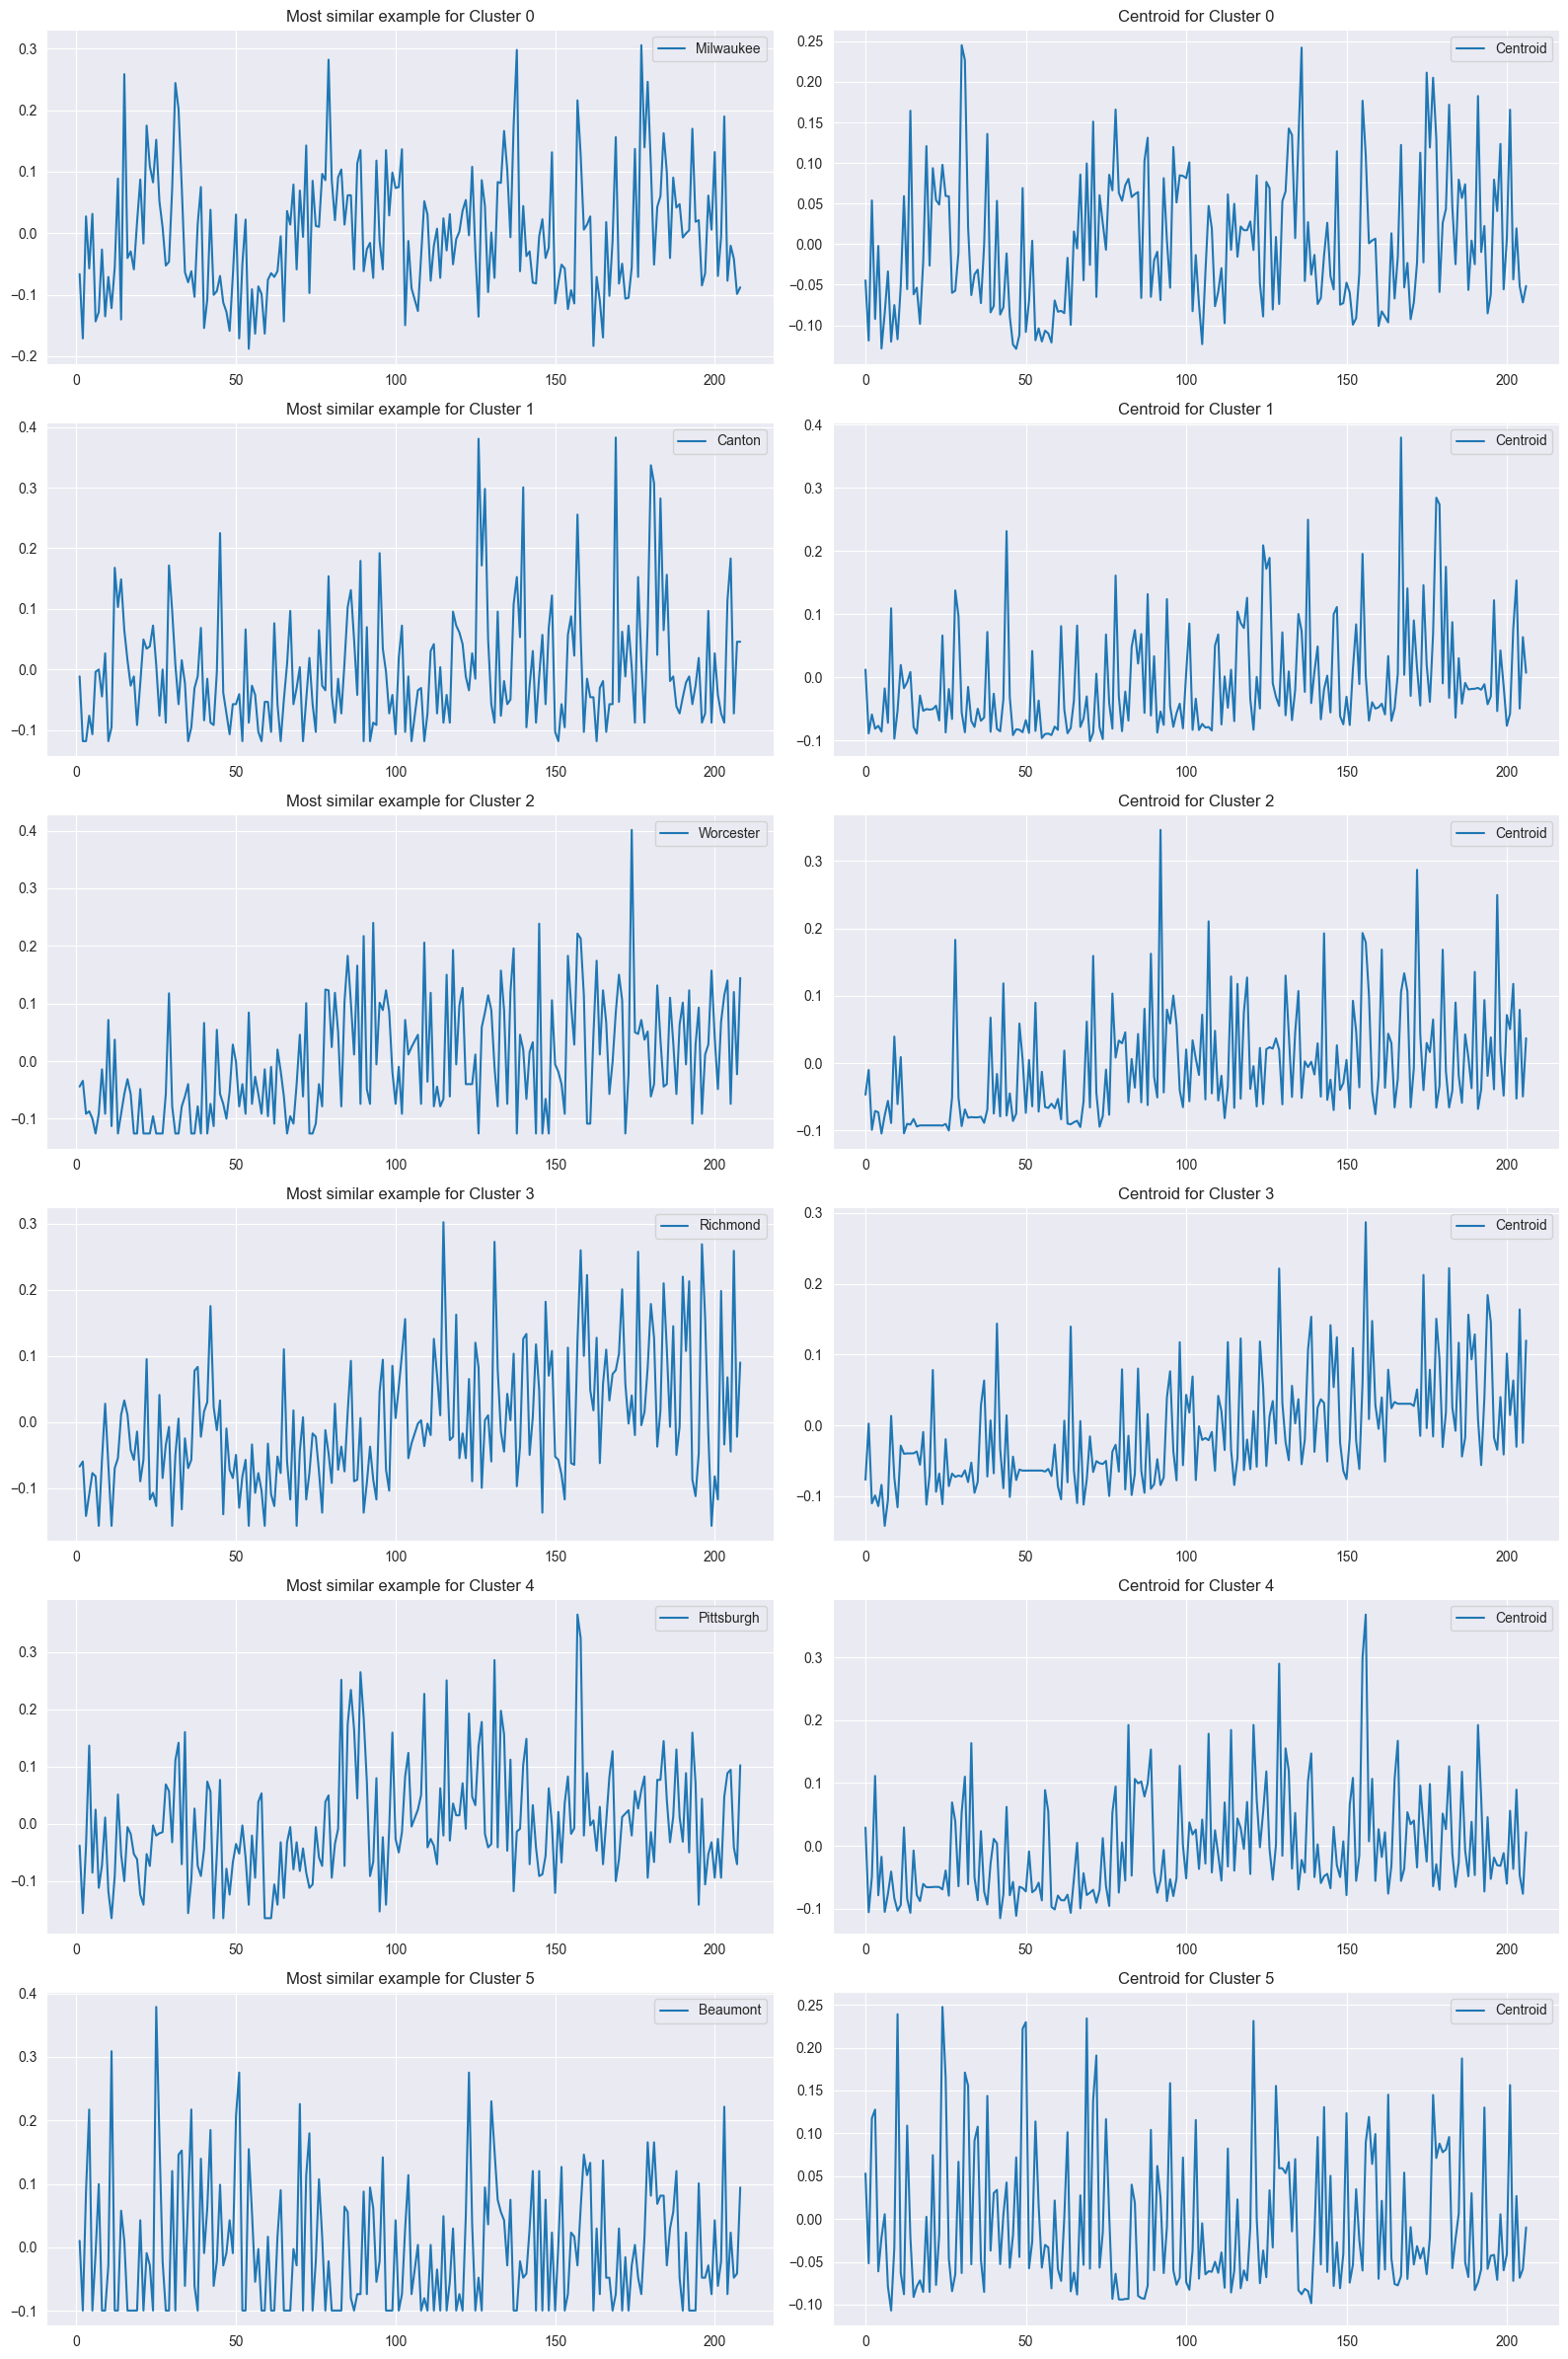

In [230]:
from tslearn.metrics import cdist_dtw
import numpy as np

kmeans_labels = kmeans_dtw.labels_
kmeans_centroids = kmeans_dtw.cluster_centers_

# Create an empty dictionary to store motifs for each cluster
cluster_ex = {}

# Find and plots the time series most similar to each cluster's centroid
unique_clusters = np.unique(kmeans_labels)
for cluster_label in unique_clusters:
    # Select time series belonging to the current cluster
    cluster_indices = np.where(kmeans_labels == cluster_label)[0]
    cluster_time_series = time_series.iloc[cluster_indices]

    # Calculate DTW distances between each series and centroid of the cluster
    centroid = kmeans_centroids[cluster_label]
    distances = cdist_dtw(cluster_time_series.values, [centroid])

    # Find the index of the time series closest to the centroid (most similar)
    most_similar_idx = np.argmin(distances)

    # Store the most similar time series as the motif for this cluster
    cluster_ex[cluster_label] = cluster_time_series.iloc[most_similar_idx]

fig, axes = plt.subplots(nrows=len(cluster_ex), ncols=2, figsize=(16, 4 * len(cluster_ex)))

for i, (cluster_label, motif) in enumerate(cluster_ex.items()):
    centroid = kmeans_centroids[cluster_label]  # Centroid for the current cluster

    axes[i, 0].plot(motif, label=motif.name)
    axes[i, 0].set_title(f'Most similar example for Cluster {cluster_label}')
    axes[i, 0].legend()

    axes[i, 1].plot(centroid, label='Centroid')
    axes[i, 1].set_title(f'Centroid for Cluster {cluster_label}')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [231]:
from matrixprofile import *
from matrixprofile.discords import discords
import matplotlib.pyplot as plt

# for each motif candidate, use find the motifs of the cluster
w = 4  # 4 weeks to look for monthly patterns

Cluster 1


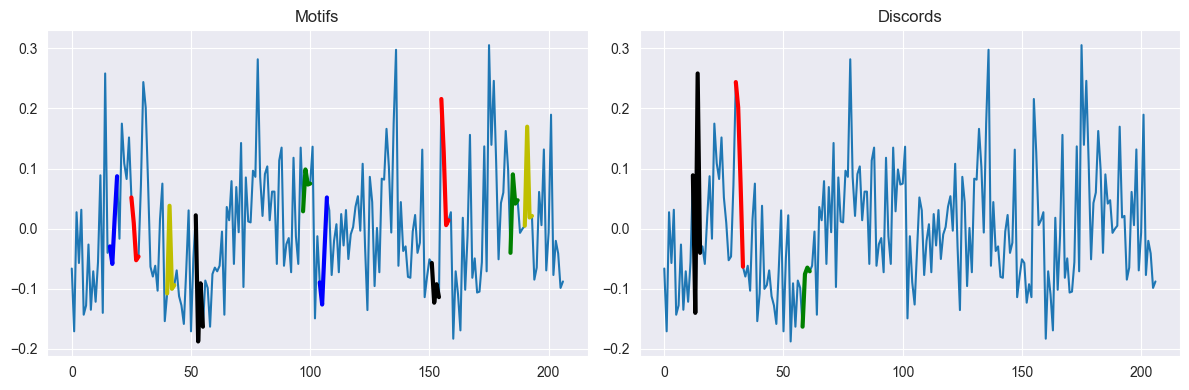

Cluster 2


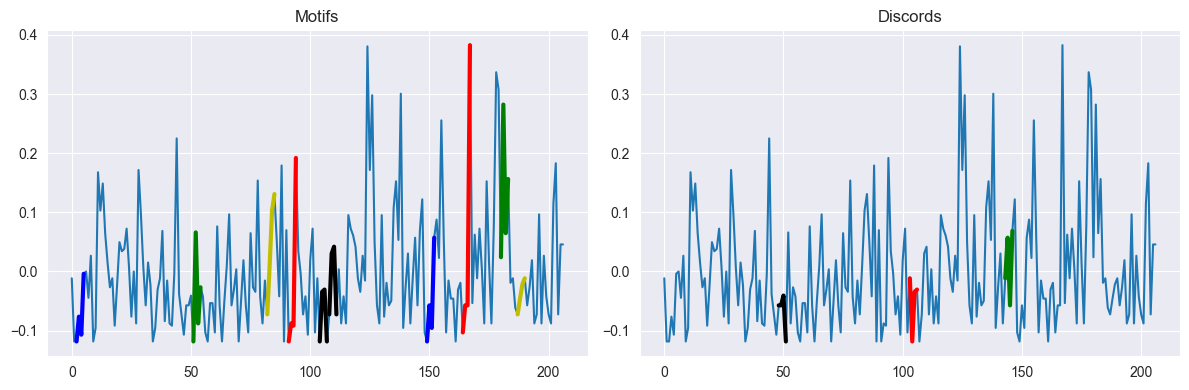

Cluster 3


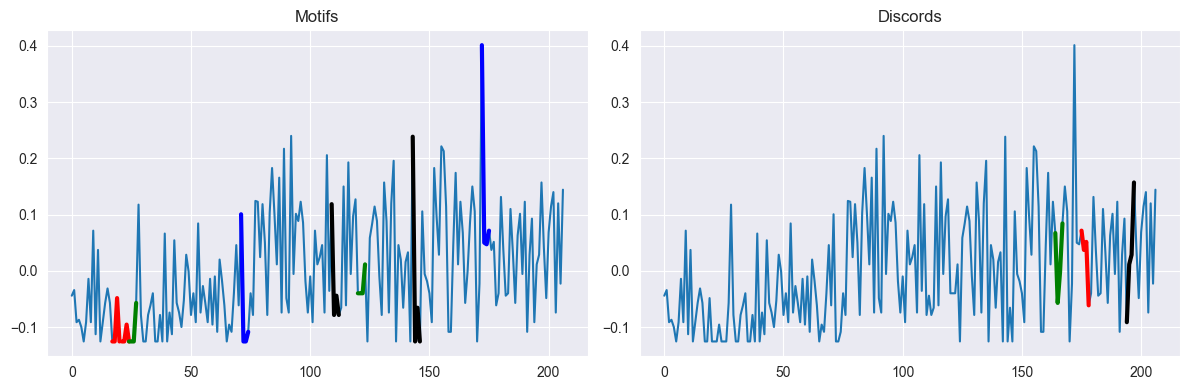

Cluster 4


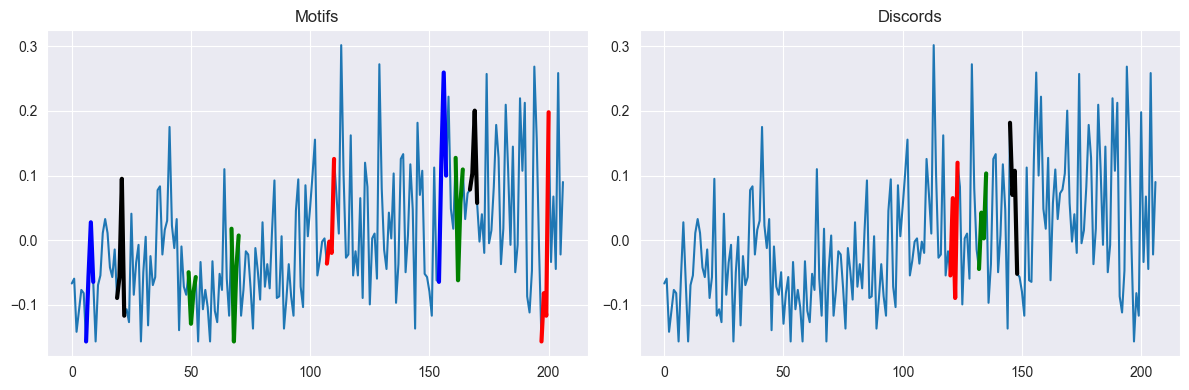

Cluster 5


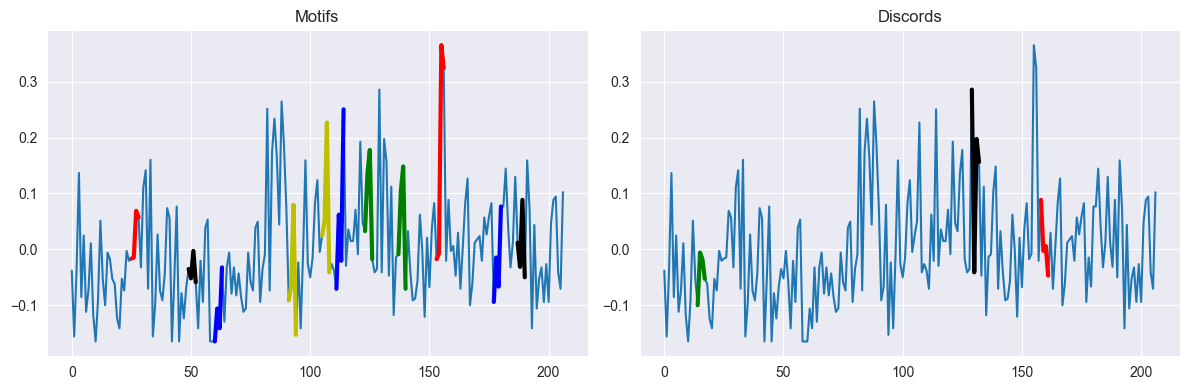

Cluster 6


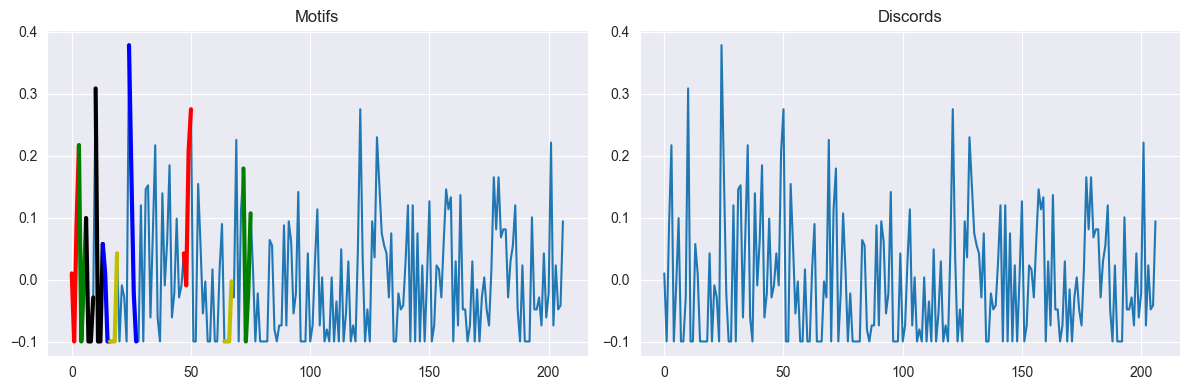

In [232]:
for cluster_label, ts in cluster_ex.items():
    print(f'Cluster {cluster_label + 1}')
    mp, mpi = matrixProfile.stomp(ts.values, w)

    mo, mod = motifs.motifs(ts.values, (mp, mpi), max_motifs=5)
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(ts.values)
    colors = ['r', 'g', 'k', 'b', 'y'][:len(mo)]
    for m, d, c in zip(mo, mod, colors):
        for i in m:
            m_shape = ts.values[i:i + w]
            plt.plot(range(i, i + w), m_shape, color=c, lw=3)
    plt.title('Motifs')

    plt.subplot(122)
    try:
        anoms = discords(mp, ex_zone=2, k=3)
    except:
        anoms = []
    plt.plot(ts.values)
    colors = ['r', 'g', 'k', 'b', 'y'][:len(anoms)]
    for a, c in zip(anoms, colors):
        a_shape = ts.values[a:a + w]
        plt.plot(range(a, a + w), a_shape, color=c, lw=3)
    plt.title('Discords')

    plt.tight_layout()
    plt.show()


# Shapelets

We reload the dataset and perform the same operations

In [233]:
df = pd.read_csv('../data/new_incidents.csv')

df = df[(df['year'] >= 2014) & (df['year'] <= 2017)]
df["is_killed"] = df["n_killed"] > 0

# Group counties by state
grouped_by_state = df.groupby('state')['city_or_county'].unique()

In [234]:
from fuzzywuzzy import fuzz

# Iterate through each state to find similar county names
for state, counties_in_state in grouped_by_state.items():
    # Iterate through each pair of counties within the state
    for i in range(len(counties_in_state)):
        for j in range(i + 1, len(counties_in_state)):
            similarity_ratio = fuzz.ratio(counties_in_state[i], counties_in_state[j])
            if similarity_ratio > 90:  # Adjust the threshold as needed
                print(
                    f"Similarity between '{counties_in_state[i]}' and '{counties_in_state[j]}' in {state} - Ratio: {similarity_ratio}")

Similarity between 'Mobile' and 'Mobile ' in Alabama - Ratio: 92
Similarity between 'Bessemer' and 'Bessemer ' in Alabama - Ratio: 94
Similarity between 'Florence' and 'Florence ' in Alabama - Ratio: 94
Similarity between 'Dekalb County' and 'DeKalb County' in Alabama - Ratio: 92
Similarity between 'Mc Calla (McCalla)' and 'Mc Calla (Mccalla)' in Alabama - Ratio: 94
Similarity between 'Mojave (county)' and 'Mohave (county)' in Arizona - Ratio: 93
Similarity between 'Little Rock' and 'Little Rock ' in Arkansas - Ratio: 96
Similarity between 'Fort Smith' and 'Fort Smith ' in Arkansas - Ratio: 95
Similarity between 'Pine Bluff' and 'Pine Bluff ' in Arkansas - Ratio: 95
Similarity between 'Helena-west Helena' and 'Helena-West Helena' in Arkansas - Ratio: 94
Similarity between 'Mc Farland' and 'McFarland' in California - Ratio: 95
Similarity between 'Santa Clarita' and 'Santa Clara' in California - Ratio: 92
Similarity between 'Hollywood' and 'Hollywood ' in California - Ratio: 95
Similarit

In [235]:
# preprocess county names to unify typos and different abbreviations
counties = df['city_or_county'].unique()
# Apply a regex-based replacement to unify the "county" suffix
df['city_or_county'] = df['city_or_county'].str.replace(r'\s+\(county\)$', ' County', regex=True)
# Replace punctuation characters with spaces
df['city_or_county'] = df['city_or_county'].str.replace(r'[^\w\s]|(?<=\w)-(?=\w)', ' ', regex=True)
# Replace 'St ' with 'Saint'
df['city_or_county'] = df['city_or_county'].str.replace(r'\bSt\b', 'Saint', regex=True)
# Replace "Pk" with "Park"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bPk\b', 'Park', regex=True)
# Replace "Mt" with "Mount"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bMt\b', 'Mount', regex=True)
# Replace "Twp" with "Township"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bTwp\b', 'Township', regex=True)
# Replace "Washingtn" with "Washington"
df['city_or_county'] = df['city_or_county'].str.replace(r'\bWashingtn\b', 'Washington', regex=True)

# Remove extra spaces
df['city_or_county'] = df['city_or_county'].str.replace(r'\s+', ' ', regex=True)
# Transform to title case and strip leading and trailing spaces
df['city_or_county'] = df['city_or_county'].str.strip().str.title()

# Mapping dictionary for unifying similar names, found with fuzzy matching
unify_dict = {
    'Denver Northglenn': 'Denver North Glenn',
    'Baton Rogue': 'Baton Rouge',
    'Marrrero': 'Marrero',
    'Prince George S County': 'Prince Georges County',
    'Genessee County': 'Genesee County',
    'O Fallon Ofallon': 'O Fallon O Fallon',
    'Doña Ana County': 'Dona Ana County',
    'Ullster County': 'Ulster County',
    'Nelsonvlle': 'Nelsonville',
    'Wolf Creek Sunnyvalley': 'Wolf Creek Sunny Valley',
    'Pittsburgh Bellvue': 'Pittsburgh Bellevue',
    'Mojave County': 'Mohave County',
    'New York Manhattan': 'Manhattan'
}

df['city_or_county'] = df['city_or_county'].replace(unify_dict)

df['date'] = pd.to_datetime(df['date'])


# Define a function to calculate the unique week index considering leap years
def calculate_unique_week(date):
    if date.year == 2016:  # account for the leap year
        return date.isocalendar().week + (date.year - 2014) * 53
    else:
        return date.isocalendar().week + (date.year - 2014) * 52


# Apply the function to create the unique week index column
df['week'] = df['date'].apply(calculate_unique_week)

Calculating a different score, not reliant on n_killed

In [236]:
df['n_minors'] = df['n_minors'].fillna(0)
df['score'] = (2 * df.n_minors) + (df.n_participants - df.n_minors)

In [237]:
grouped = df.groupby([df['city_or_county'],
                      df['week']])['score'].sum().reset_index()

ts = grouped.pivot(index='city_or_county', columns='week', values=['score'])
ts.fillna(0, inplace=True)

In [238]:
target_df = df.drop_duplicates(subset='city_or_county')
Y = target_df['is_killed']

In [239]:
from sklearn.model_selection import train_test_split

X = ts.values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [240]:
n_ts, ts_sz = X_train.shape
n_classes = 2

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.02,
                                                       r=1)
print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 8827
ts_sz 207
n_classes 2
shapelet_sizes {4: 6}


In [241]:
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            max_iter=100,
                            random_state=42,
                            verbose=1)
shp_clf.fit(X_train, y_train)
y_pred_test = shp_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_test))

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.5469 - binary_crossentropy: 89.5409 - loss: 89.5250
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5713 - binary_crossentropy: 25.8676 - loss: 25.8617
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5461 - binary_crossentropy: 18.1356 - loss: 18.1456
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5882 - binary_crossentropy: 12.5001 - loss: 12.5079
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5816 - binary_crossentropy: 9.3189 - loss: 9.3252
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5884 - binary_crossentropy: 7.8761 - loss: 7.8815
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5669 - binary_crossentropy: 7.0203 - loss: 7.0235
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5801 - binary_crossentropy: 6.4622 - loss: 6.4664
Epoch 9/100
35/3

We create the shapelet model

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


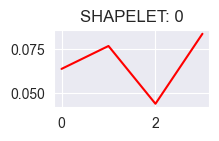

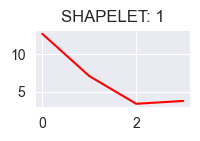

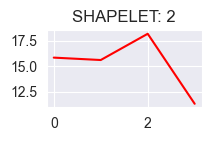

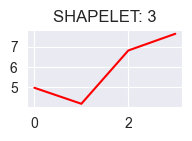

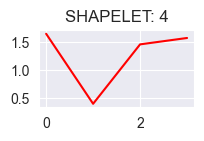

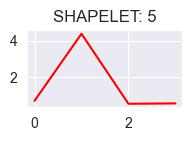

In [242]:
predicted_locations = shp_clf.locate(X_test)
for i, shp in enumerate(shp_clf.shapelets_as_time_series_):
    plt.figure(figsize=(2, 1))
    plt.title(f"SHAPELET: {i}")
    plt.plot(shp, color='red')
    plt.show()

We apply it on a timeseries to see how close it is

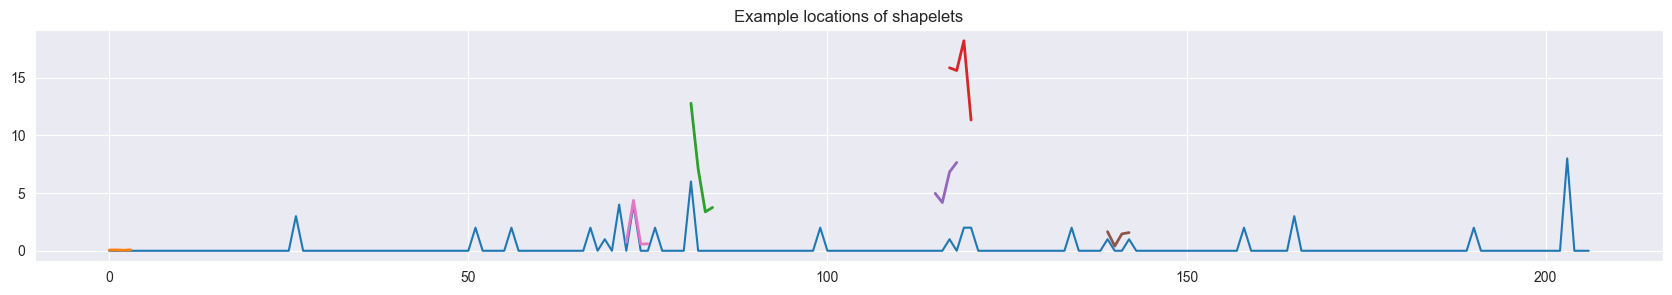

In [243]:
ts_id = 1
plt.figure(figsize=(21., 3.))
plt.plot(X_test[ts_id].ravel())
count = 0
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
plt.title("Example locations of shapelets")
plt.show()

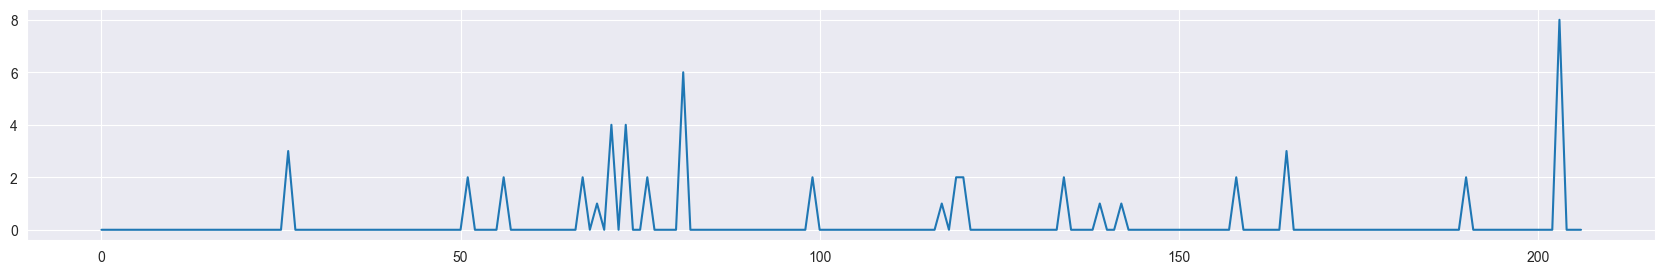

In [244]:
plt.figure(figsize=(21., 3.))
plt.plot(X_test[ts_id].ravel())
plt.show()